Output()

Epoch  0/14, loss=0.0000, val_loss=1.3876 ,f1=nan, val_f1=0.1049 ,acc=nan, val_acc=0.1022

Output()

Output()

Epoch  1/14, loss=0.5159, val_loss=0.3837 ,f1=0.5475, val_f1=0.4899 ,acc=0.7836, 
val_acc=0.7824

Output()

Output()

Epoch  2/14, loss=0.3066, val_loss=0.3144 ,f1=0.6146, val_f1=0.5871 ,acc=0.8564, 
val_acc=0.8181

Output()

Output()

Epoch  3/14, loss=0.2575, val_loss=0.2335 ,f1=0.7257, val_f1=0.7903 ,acc=0.8793, 
val_acc=0.9046

Output()

Output()

Epoch  4/14, loss=0.1867, val_loss=0.1778 ,f1=0.8299, val_f1=0.8339 ,acc=0.9202, 
val_acc=0.9262

Output()

Output()

Epoch  5/14, loss=0.1506, val_loss=0.1702 ,f1=0.8548, val_f1=0.8374 ,acc=0.9338, 
val_acc=0.9273

Output()

Output()

Epoch  6/14, loss=0.1354, val_loss=0.1595 ,f1=0.8647, val_f1=0.8465 ,acc=0.9389, 
val_acc=0.9321

Output()

Output()

Epoch  7/14, loss=0.1278, val_loss=0.1496 ,f1=0.8703, val_f1=0.8492 ,acc=0.9413, 
val_acc=0.9339

Output()

Output()

Epoch  8/14, loss=0.1207, val_loss=0.1467 ,f1=0.8761, val_f1=0.8544 ,acc=0.9439, 
val_acc=0.9360

Output()

Output()

Epoch  9/14, loss=0.1160, val_loss=0.1438 ,f1=0.8801, val_f1=0.8568 ,acc=0.9457, 
val_acc=0.9372

Output()

Output()

Epoch 10/14, loss=0.1140, val_loss=0.1415 ,f1=0.8827, val_f1=0.8641 ,acc=0.9466, 
val_acc=0.9395

Output()

Output()

Epoch 11/14, loss=0.1086, val_loss=0.1377 ,f1=0.8849, val_f1=0.8656 ,acc=0.9482, 
val_acc=0.9407

Output()

Output()

Epoch 12/14, loss=0.1067, val_loss=0.1352 ,f1=0.8867, val_f1=0.8650 ,acc=0.9490, 
val_acc=0.9405

Output()

Output()

Epoch 13/14, loss=0.1032, val_loss=0.1330 ,f1=0.8894, val_f1=0.8672 ,acc=0.9503, 
val_acc=0.9413

Output()

Output()

Epoch 14/14, loss=0.1011, val_loss=0.1339 ,f1=0.8906, val_f1=0.8665 ,acc=0.9510, 
val_acc=0.9412

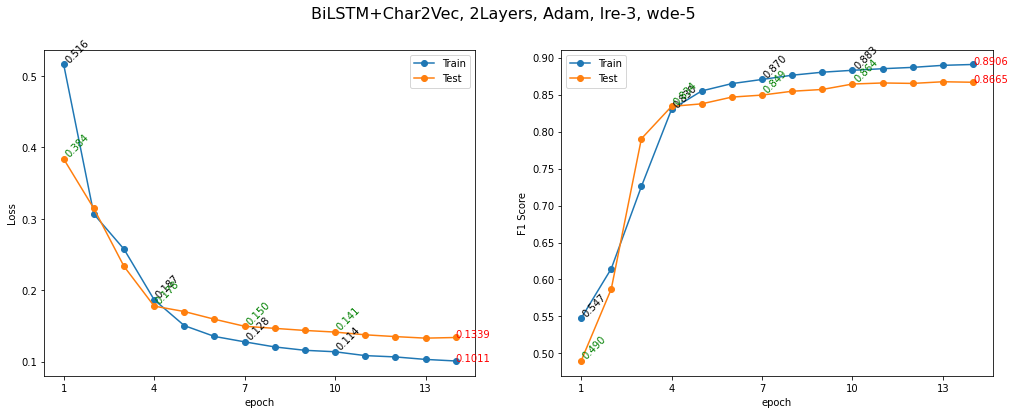

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from data import Data, train_loader, test_loader
from config import CFG
from utils import *
from char2vec import BiLSTMtagger

from tqdm import tqdm
from rich import print
from rich.progress import track
from datetime import datetime

from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(CFG.seed)

EMBEDDING_DIM = 3*CFG.out_ch2
HIDDEN_DIM = 128
TAGSET_SIZE = Data.label_vocab_size # en, es, other

model = BiLSTMtagger(EMBEDDING_DIM, HIDDEN_DIM, TAGSET_SIZE)
loss_function = nn.CrossEntropyLoss()#nn.NLLLoss()
# optimizer = optim.SGD(model.parameters(), lr=CFG.lr)
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=150, factor=0.1, min_lr=1e-8)

logs = defaultdict(list)

best_val_score = 0

for epoch in (range(CFG.n_epochs+1)):

    model.train()  # again, normally you would NOT do 300 epochs, it is toy data
    avg_loss = 0
    train_targets, train_preds = [], []
    if epoch!=0:
        for sentence, label in track(train_loader,
                    description="Training...", total=len(train_loader), transient=True):
            model.zero_grad()
            scores = model(sentence)
            loss = loss_function(scores.view(-1,scores.shape[-1]), label.view(-1))
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()/len(train_loader)
            train_targets.extend(flatten(label))
            train_preds.extend(flatten(scores.argmax(axis=-1)))

    model.eval()
    avg_val_loss = 0
    val_targets, val_preds = [], []
    for sentence, label in track(test_loader,
                description="Validating...", total=len(test_loader), transient=True):
        scores = model(sentence)
        avg_val_loss += loss_function(scores.view(-1,scores.shape[-1]), label.view(-1)).item()/len(test_loader)
        val_targets.extend(flatten(label))
        val_preds.extend(flatten(scores.argmax(axis=-1)))

    scheduler.step(avg_val_loss)

    #Calculate F1-score, accuracy_score
    train_eval = evaluation(train_targets, train_preds, metrics=['f1', 'accuracy'])
    val_eval   = evaluation(val_targets,   val_preds,   metrics=['f1', 'accuracy'])

    width = len(str(CFG.n_epochs))
    print(f"Epoch {epoch:{width}}/{CFG.n_epochs}, loss={avg_loss:.4f}, val_loss={avg_val_loss:.4f}\
 ,f1={train_eval['f1']:.4f}, val_f1={val_eval['f1']:.4f}\
 ,acc={train_eval['accuracy']:.4f}, val_acc={val_eval['accuracy']:.4f}")
    if epoch!=0:
        logs['train_loss'].append(avg_loss)
        logs['val_loss'].append(avg_val_loss)
        logs['train_f1'].append(train_eval['f1'])
        logs['val_f1'].append(val_eval['f1'])
        logs['train_accuracy'].append(train_eval['accuracy'])
        logs['val_accuracy'].append(val_eval['accuracy'])
    # saving the best model
    if best_val_score < val_eval['f1']:
        best_val_score = val_eval['f1']
        best_model = model

torch.save(best_model.state_dict(), f'../saved-models/model-[{datetime.now().strftime("%y%m%d%H%M")}]{max(logs["val_f1"]):.5f}.pth'.replace('0.','.'))
torch.save(best_model.state_dict(), '../saved-models/bestmodel.pth')

res_plot(logs, desc="BiLSTM+Char2Vec, 2Layers, Adam, lre-3, wde-5")


In [12]:
EMBEDDING_DIM = 3*CFG.out_ch2
HIDDEN_DIM = 128
TAGSET_SIZE = Data.label_vocab_size # pad, en, es, other

def predict(text):
    model = BiLSTMtagger(EMBEDDING_DIM, HIDDEN_DIM, TAGSET_SIZE)
    state = torch.load('../saved-models/bestmodel.pth')
    model.load_state_dict(state)
    model.eval()
    tokens = text.split()
    x = Data.embedding_s(Data.chr2id, [tokens+['.']])
    out = model(torch.LongTensor(x)).argmax(dim=-1)[0].tolist()
    labels = [Data.id2lbl[i] for i in out]

    return labels[:-1]

texts = ["@andres_romero17 si , prometo hacer un audio :)", "This is an audio book !",
         "@andres98 love his laptoooop soooooo much, si si  :)"]
for text in texts:
    print(predict(text))

['en', 'es', 'other', 'es', 'es', 'es', 'es', 'other']

['es', 'en', 'en', 'en', 'en', 'other']

['es', 'en', 'en', 'en', 'es', 'es', 'es', 'es', 'other']

In [16]:
best_model

BiLSTMtagger(
  (word_embeddings): Char2Vec(
    (embeds): Embedding(300, 9)
    (conv1): Sequential(
      (0): Conv1d(9, 15, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (convs2): ModuleList(
      (0): Sequential(
        (0): Conv1d(15, 7, kernel_size=(3,), stride=(1,))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv1d(15, 7, kernel_size=(4,), stride=(1,))
        (1): ReLU()
      )
      (2): Sequential(
        (0): Conv1d(15, 7, kernel_size=(5,), stride=(1,))
        (1): ReLU()
      )
    )
    (linear): Sequential(
      (0): Linear(in_features=21, out_features=21, bias=True)
      (1): ReLU()
    )
  )
  (lstm): LSTM(21, 128, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (hidden2tag): Linear(in_features=256, out_features=4, bias=True)
)

In [24]:
from torchsummary import summary
summary(best_model)

Layer (type:depth-idx)                   Param #
├─Char2Vec: 1-1                          --
|    └─Embedding: 2-1                    2,700
|    └─Sequential: 2-2                   --
|    |    └─Conv1d: 3-1                  420
|    |    └─ReLU: 3-2                    --
|    |    └─Dropout: 3-3                 --
|    └─ModuleList: 2-3                   --
|    |    └─Sequential: 3-4              322
|    |    └─Sequential: 3-5              427
|    |    └─Sequential: 3-6              532
|    └─Sequential: 2-4                   --
|    |    └─Linear: 3-7                  462
|    |    └─ReLU: 3-8                    --
├─LSTM: 1-2                              549,888
├─Linear: 1-3                            1,028
Total params: 555,779
Trainable params: 555,779
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Char2Vec: 1-1                          --
|    └─Embedding: 2-1                    2,700
|    └─Sequential: 2-2                   --
|    |    └─Conv1d: 3-1                  420
|    |    └─ReLU: 3-2                    --
|    |    └─Dropout: 3-3                 --
|    └─ModuleList: 2-3                   --
|    |    └─Sequential: 3-4              322
|    |    └─Sequential: 3-5              427
|    |    └─Sequential: 3-6              532
|    └─Sequential: 2-4                   --
|    |    └─Linear: 3-7                  462
|    |    └─ReLU: 3-8                    --
├─LSTM: 1-2                              549,888
├─Linear: 1-3                            1,028
Total params: 555,779
Trainable params: 555,779
Non-trainable params: 0